In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from lib import forward_diffusion, reverse_diffusion, DDPM, make_schedule
from lib_ddrm_fast import DDRM_fast
from lib_svd import Deblurring
from unet import UNetModel
from torchvision.transforms import ToTensor, Compose, PILToTensor, Normalize, Resize
import os
from PIL import Image

N=84480 train samples in turbrot


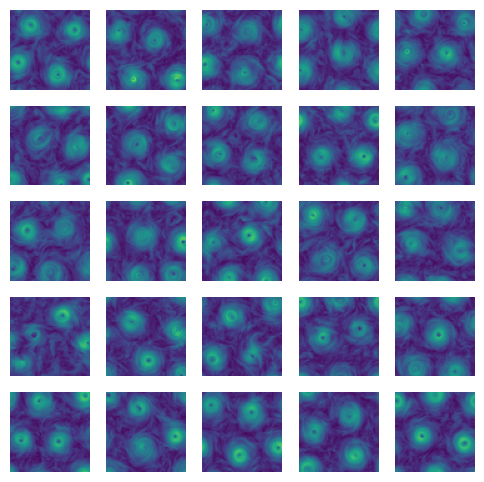

In [2]:
#Visualize turbrot images
turbrot_dataset_root = '/mimer/NOBACKUP/groups/azizpour-group-alvis/bharath/datasets/turbrot'
turbrot_train_dataset_orig = np.load(os.path.join(turbrot_dataset_root,"turbrot_train.npy"))
N = len(turbrot_train_dataset_orig)
print(f"N={N} train samples in turbrot")
num_samples = 25
h, w = int(np.sqrt(num_samples)), int(np.sqrt(num_samples))
assert h*w == num_samples
f, ax = plt.subplots(ncols=w, nrows=h, figsize=(1.2*w,1.2*h))
samples = np.random.choice(np.arange(N),size=num_samples)
for id, sample in enumerate(samples):
    image = turbrot_train_dataset_orig[sample]
    #image = np.array(image)
    #print(image.shape)
    r = id//w
    c = id - (r*w)
    ax[r,c].imshow(image,vmin=-1.25,vmax=1.25)
    ax[r,c].axis('off')

Text(0.5, 0, 'rvar')

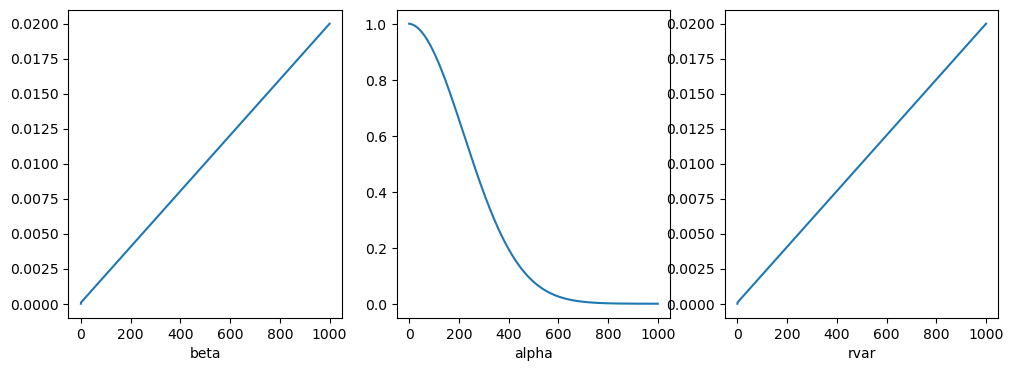

In [3]:
T = 1000
schedule = make_schedule(scheme='linear', rvar='beta', T=T, start_beta=1e-4, end_beta=0.02)
f, ax = plt.subplots(ncols=3,figsize=(12,4))
ax[0].plot(np.arange(start=0,stop=T+1),schedule['beta'])
ax[0].set_xlabel('beta')
ax[1].plot(np.arange(start=0,stop=T+1),schedule['alpha'])
ax[1].set_xlabel('alpha')
ax[2].plot(np.arange(start=0,stop=T+1),schedule['rvar'])
ax[2].set_xlabel('rvar')
#print(schedule['alpha'])

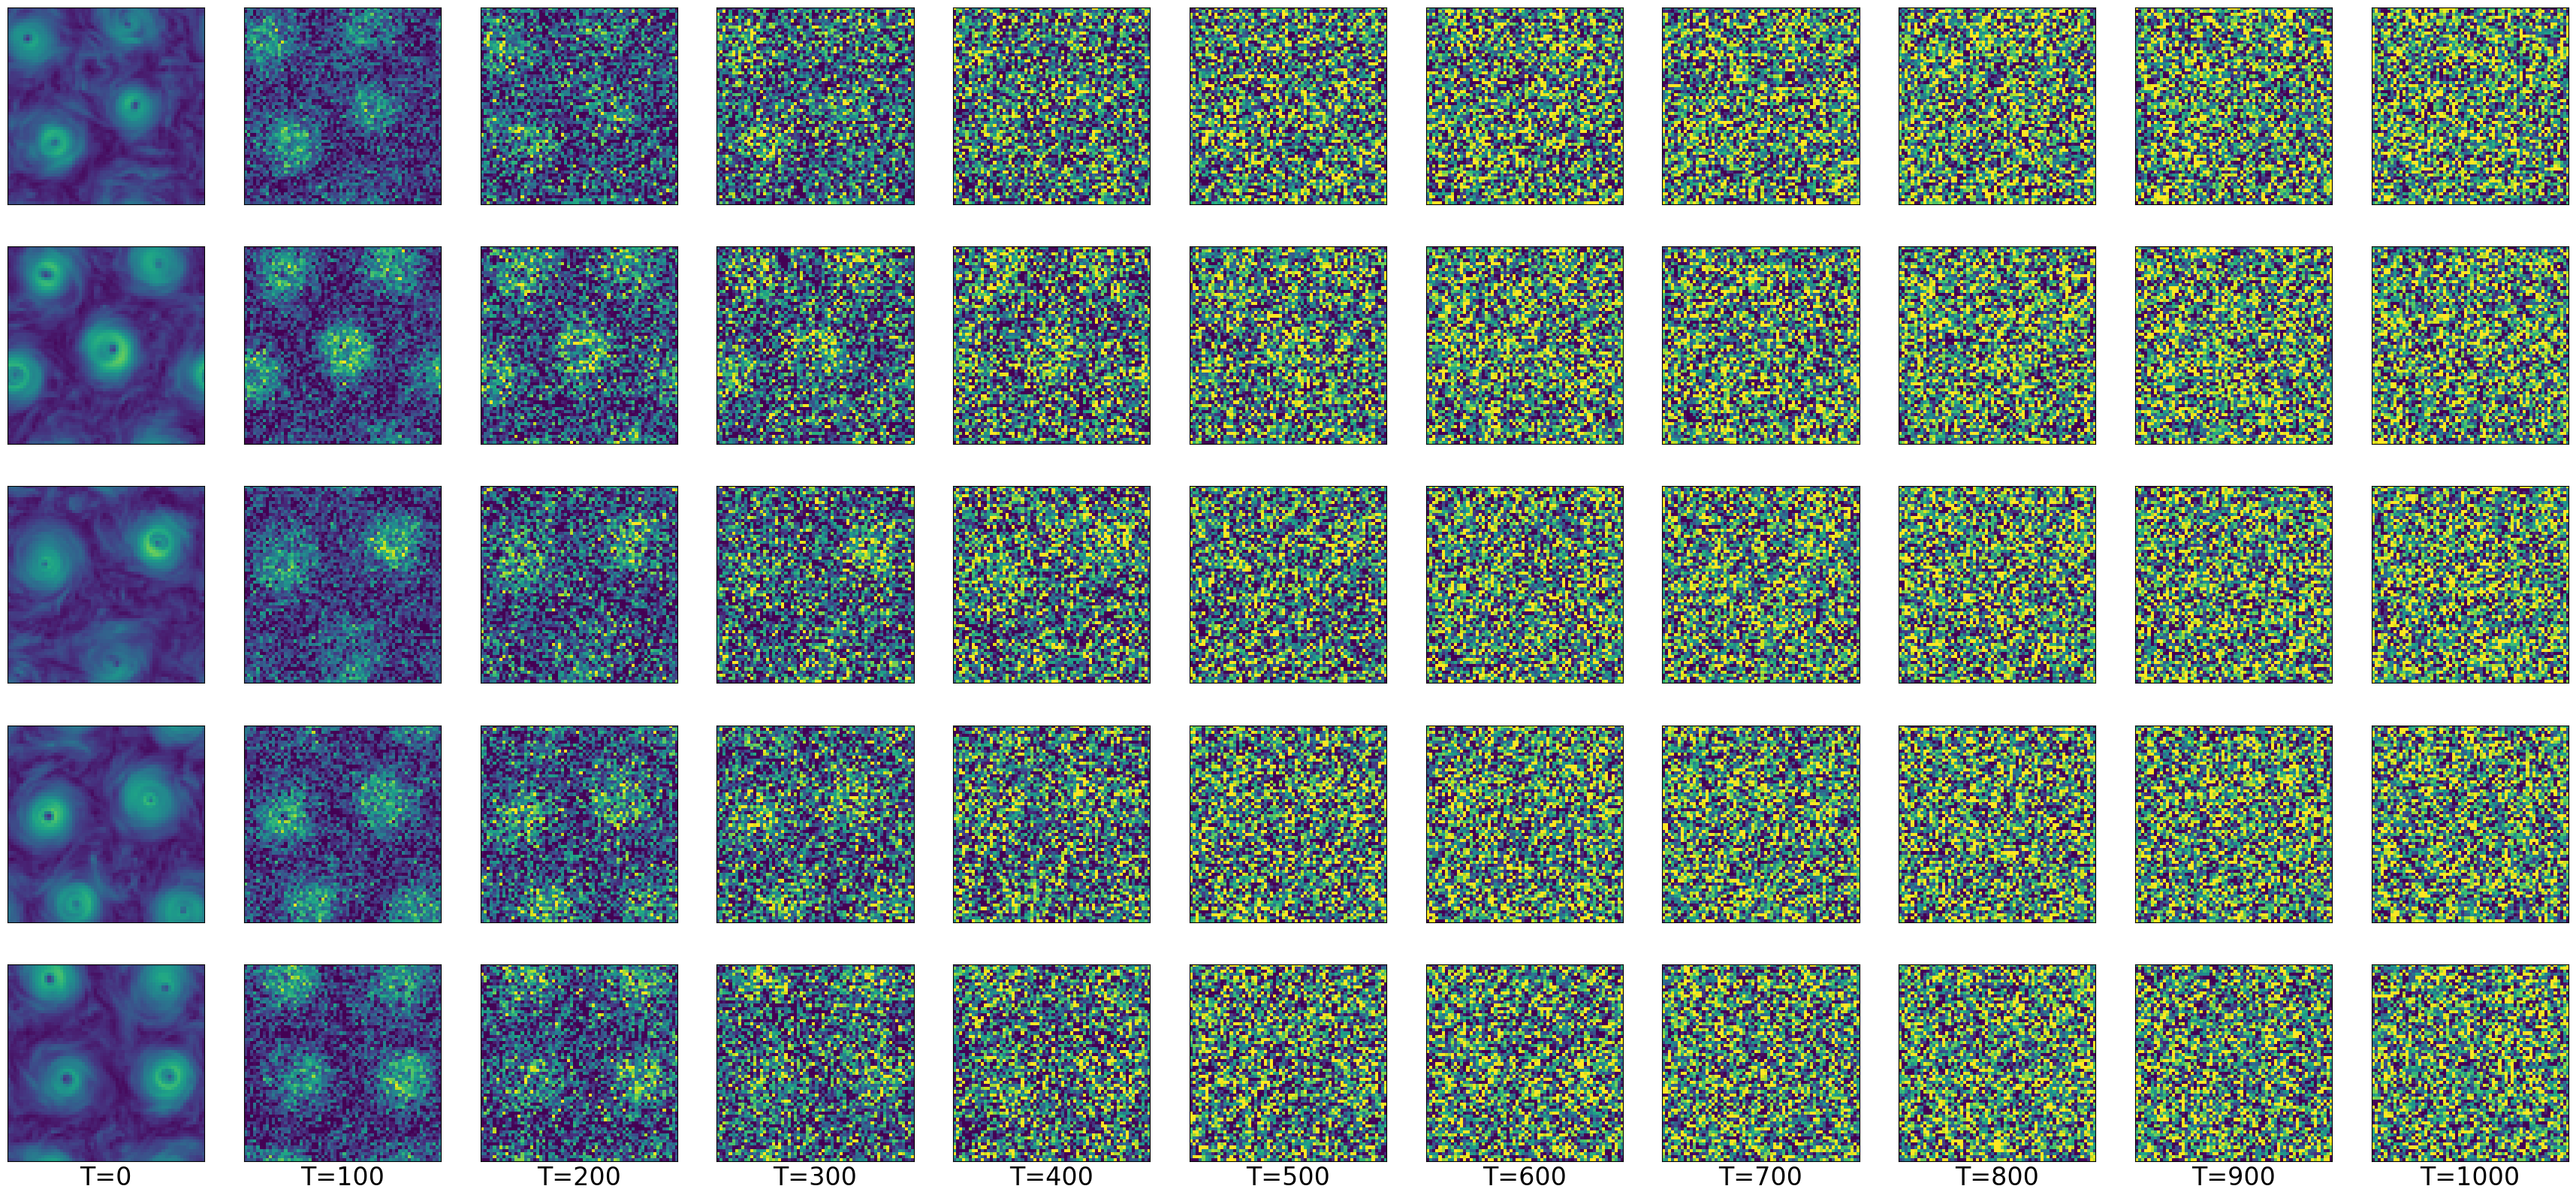

In [4]:
numtime = 11
numsamples = 5
f, ax = plt.subplots(ncols=numtime, nrows=numsamples, figsize=(4*numtime,4*numsamples))
samples = np.random.choice(np.arange(len(turbrot_train_dataset_orig)),size=numsamples)
for idx,t in enumerate(np.linspace(start=0, stop=T, endpoint=True, num=numtime)):
    t = int(t)
    for idy, sample in enumerate(samples):
        image = turbrot_train_dataset_orig[sample]
        image = np.array(image, dtype=np.float32)/1.25
        #image = np.array(image)
        image_t = forward_diffusion(image, 0, t, schedule)
        #ax[idy, idx].imshow(np.asarray(np.clip(image_t*255,a_min=0,a_max=255),dtype=np.uint8))    
        ax[idy, idx].imshow(image_t,vmin=-1.0,vmax=1.0)
        #ax[idy, idx].set_xlabel('T='+str(t))
        ax[idy, idx].set_xticks([])
        ax[idy, idx].set_yticks([])
        if idy == len(samples)-1:
            ax[idy, idx].set_xlabel('T='+str(t), fontsize=24)

In [5]:
class unet_turbrot_classic(torch.nn.Module):
    
    def __init__(self,):
        super().__init__()
        self.model = UNetModel(image_size=64,
                            in_channels=1,
                            model_channels=32,
                            out_channels=1,
                            num_res_blocks=2,
                            attention_resolutions=[2,8],
                            dropout=0,
                            channel_mult=(1, 2, 2, 2),
                            conv_resample=True,
                            dims=2,
                            num_classes=None,
                            use_checkpoint=False,
                            use_fp16=False,
                            num_heads=1,
                            num_head_channels=-1,
                            num_heads_upsample=-1,
                            use_scale_shift_norm=False,
                            resblock_updown=False,
                            use_new_attention_order=False)

    def forward(self, x, t):
        return self.model(x, t)

In [6]:

def infer(ddpm_model, schedule, num_samples):
    
    z = np.random.normal(loc=0, scale=1.0, size=(num_samples,1,64,64))
    z = np.asarray(z, dtype=np.float32)
    x = z
    for t in range(0,T):
        x = reverse_diffusion(ddpm_model=ddpm_model, x=x, t_curr=T-t, cuda=True, schedule=schedule, onlymean=False)
    pred_samples = x
    assert pred_samples.shape == z.shape
    h, w = int(np.sqrt(num_samples)), int(np.sqrt(num_samples))
    assert h*w == num_samples
    f, ax = plt.subplots(ncols=w, nrows=h, figsize=(1.2*w,1.2*h))
    for id in range(num_samples):
        image  = pred_samples[id]
        image = np.transpose(image,(1,2,0))
        image = image*1.25 
        image = np.clip(image, a_min=-1.25, a_max=1.25)
        r = id//w
        c = id - (r*w)
        ax[r,c].imshow(image,vmin=-1.25,vmax=1.25)
        ax[r,c].axis('off')



In [7]:
model = unet_turbrot_classic()
model.load_state_dict(torch.load('./ckpts/turbrot-classic-60.ckpt')['model_state_dict'])
ddrm_model = DDRM_fast(schedule=schedule,model=model,weightedloss=False,cuda=True)
#train(ddpm_model, num_epochs=200, batch_size=32, savefreq=50, prefix='flowers102-uwl')

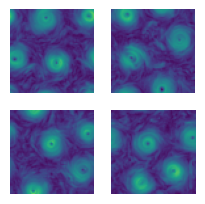

In [8]:
infer(ddrm_model, schedule, num_samples=4)

In [9]:
def visualize_degradation(numsamples, sigma_y=0.0, eta=1.0, eta_b=1.0, T_ddrm=20, seed=42, onlymean=False):

    device = torch.device("cuda")
    H = Deblurring(torch.Tensor([1/9] * 9).to(device), 1, 64, device)
    print(H.singulars().shape)
    turbrot_dataset_root = '/mimer/NOBACKUP/groups/azizpour-group-alvis/bharath/datasets/turbrot'
    turbrot_train_dataset_orig = np.load(os.path.join(turbrot_dataset_root,"turbrot_train.npy"))
    N = len(turbrot_train_dataset_orig)
    print(f"N={N} train samples in turbrot")

    
    numcols = 3

    f, ax = plt.subplots(ncols=numcols, nrows=numsamples, figsize=(4*numcols,4*numsamples))
    #below changing size to None-> returns a single scalar and duplicating the same sample, so as to check the diversity of generations
    np.random.seed(seed)
    samples = np.random.choice(np.arange(len(turbrot_train_dataset_orig)),size=None,replace=False)
    samples = [samples]*numsamples
    
    for idx,sample in enumerate(samples):
        image = turbrot_train_dataset_orig[sample]
        image = np.array(image, dtype=np.float32)
        print(image.shape)

        ax[idx, 0].imshow(image,vmin=-1.25,vmax=1.25)    
        ax[idx, 0].set_xticks([])
        ax[idx, 0].set_yticks([])

        orig_shape = image.shape
        image_degraded = H.H(torch.tensor(image, device=device).reshape((1,1,64,64)))
        y = image_degraded.clone()
        image_degraded = image_degraded.reshape((64,64,1)).cpu().numpy()
        
        ax[idx, 1].imshow(image_degraded,vmin=-1.25,vmax=1.25)    
        ax[idx, 1].set_xticks([])
        ax[idx, 1].set_yticks([])

        #image_n = image / 1.25
        #image_t = np.transpose(image_n, (2,0,1))
        #y = np.array([H @ image_t.reshape((-1,))])
        y = y/1.25
        #recovered_image = ddrm_model.reverse_diffusion_ddrm(torch.randn(1,1,64,64) ,y, sigma_y=sigma_y, eta=eta, eta_b=eta_b, T_ddrm=T_ddrm, cuda=True, onlymean=onlymean, ddpminputshape=-1)
        recovered_image = ddrm_model.reverse_diffusion_ddrm(torch.randn(1,1,64,64), y, sigma_y=sigma_y, eta=eta, eta_b=eta_b, inp_channels=1, image_size=64, task='deblur', T_ddrm=20, cuda=True, onlymean=False, ddpminputshape=None)
        recovered_image = recovered_image.cpu().numpy()
        recovered_image = np.transpose(recovered_image.reshape((1,64,64)),(1,2,0))
        recovered_image = recovered_image*1.25
        
        ax[idx, 2].imshow(recovered_image,vmin=-1.25,vmax=1.25)    
        ax[idx, 2].set_xticks([])
        ax[idx, 2].set_yticks([])
        
        if idx == len(samples)-1:
            ax[idx, 0].set_xlabel('Original sample', fontsize=6*numcols)
            ax[idx, 1].set_xlabel('Degraded sample', fontsize=6*numcols)
            ax[idx, 2].set_xlabel('Recovered sample', fontsize=6*numcols)

def get_random_mask(h,w,c, masktype="random"):
    
    n = h*w*c    
    
    box_mask = np.zeros((h,w))
    box_mask[20:50,15:45] = 1
    box_mask = np.bool_(box_mask.reshape((-1,)))   
    random_mask = np.random.choice(np.arange(h*w),replace=False,size=int(0.5*h*w))
    
    if masktype == "random":
        mask = random_mask
    elif masktype == "box":
        mask = box_mask
    
    Z = np.ones((h,w),).reshape((-1))
    Z[mask] = 0

    H = np.ones((c,h,w)) * Z.reshape((1,h,w))
    Hvis = np.ones((h,w,c)) * Z.reshape((h,w,1))
    H = np.diag(H.reshape((-1)))
    Hvis = np.diag(Hvis.reshape((-1)))
    assert H.shape == (n,n) and Hvis.shape == (n,n) 
    return H, Hvis


torch.Size([4096])
N=84480 train samples in turbrot
(64, 64, 1)


(64, 64, 1)
(64, 64, 1)


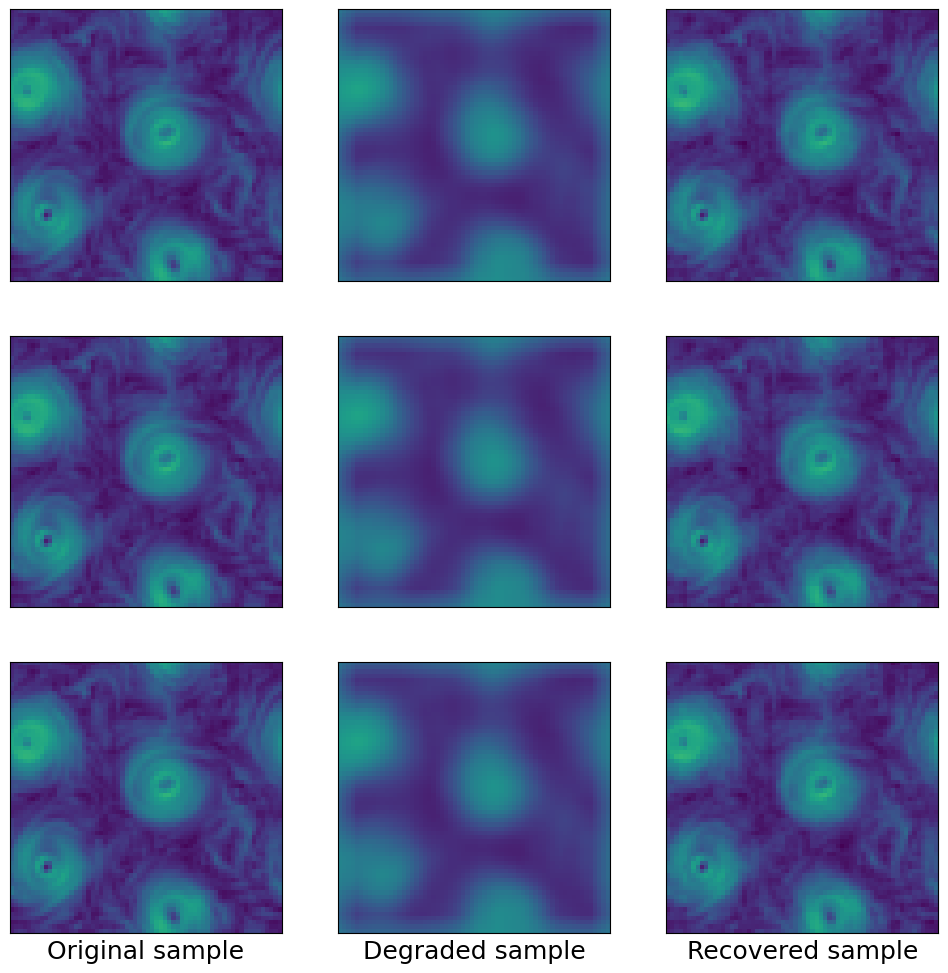

In [16]:
#visualize_degradation(*get_random_mask(64,64,1, masktype="box"), numsamples=3, sigma_y=0.0, eta=1.0, eta_b=1.0, T_ddrm=20, seed=100, onlymean=False)
visualize_degradation(numsamples=3, sigma_y=0.0, eta=0.85, eta_b=1.0, T_ddrm=20, seed=100, onlymean=False)

In [11]:
visualize_degradation(*get_random_mask(64,64,1, masktype="random"), numsamples=3, sigma_y=0.0, eta=0.85, eta_b=1.0, T_ddrm=20, seed=100, onlymean=False)

TypeError: visualize_degradation() got multiple values for argument 'numsamples'

N=84480 train samples in turbrot
(64, 64, 1)
(64, 64, 1)
(64, 64, 1)


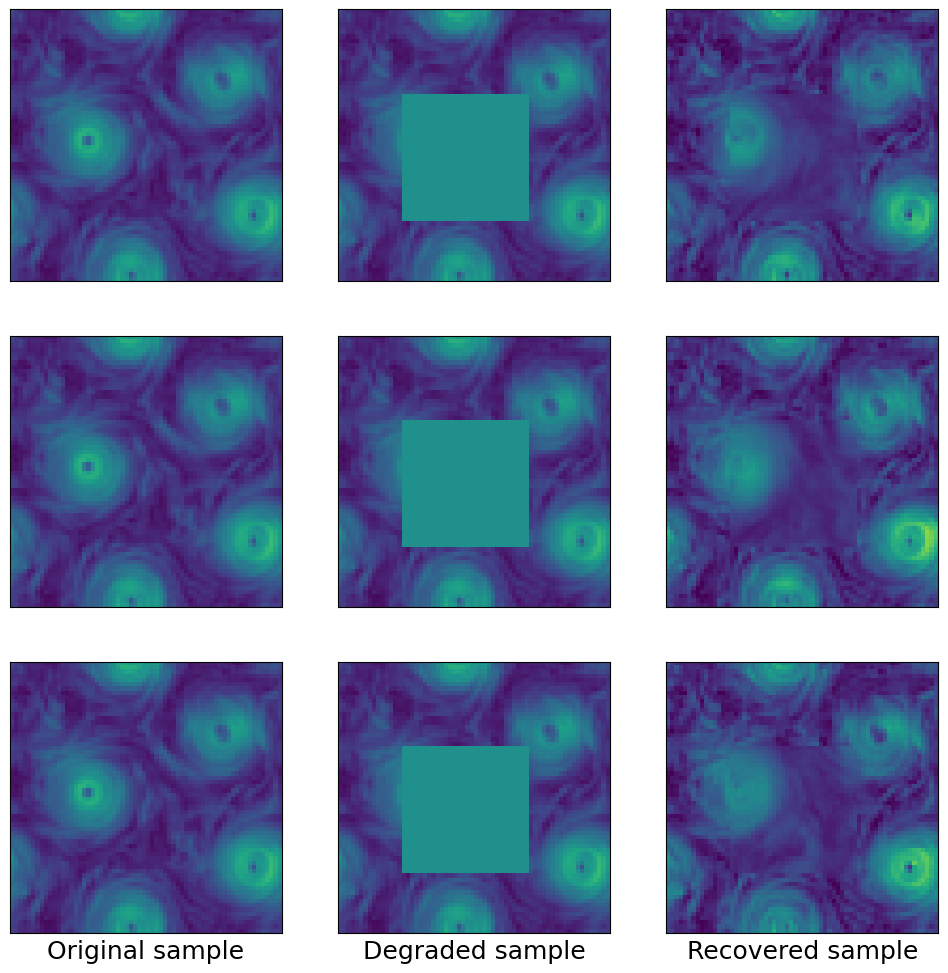

In [ ]:
visualize_degradation(*get_random_mask(64,64,1, masktype="box"), numsamples=3, sigma_y=0.0, eta=1.0, eta_b=2.0, T_ddrm=20, seed=1000, onlymean=False)